# 0 - Présentation

## 🌍 Project Overview

This project leverages a Convolutional Variational Autoencoder (CVAE) to reconstruct the climatic signal, focusing on tasmax (daily maximum temperature). The goal is to quantify climatic anomalies in future scenarios based on how well the model can reproduce known climate dynamics.


## 🧠 Objective

We train the model on historical climate data from 1850 to 2000, and test its ability to reconstruct unseen data from 2000 to 2015. After that, we use the trained model to perform inference on future climate projections up to the year 2100.


## 🔍 Methodology

The model is trained to reconstruct seasonal temperature signals using past climate data.

We compute the difference between the model’s prediction and a reference climatic signal, typically from a given SSP (Shared Socioeconomic Pathway) scenario.

Large reconstruction errors indicate that the model struggles to reproduce high-frequency components — these correspond to climatic anomalies.

By analyzing these reconstruction errors, we can detect and quantify anomalies in the projected data.

## 📊 Analysis

Once the anomalies are identified, we can:

- Count their frequency and magnitude

- Track their evolution over time

- Compare different SSP scenarios based on anomaly patterns

## ❄️ Season-Specific Modeling

To capture seasonal dynamics more accurately, we chose to:

- Train a separate CVAE for each season

- Split the dataset accordingly so that each model learns from climate signals corresponding only to one season

This approach allows the models to specialize in the patterns and variabilities unique to each time of year.

# 1 - Import des modules

Pip install the  clemoule/xtclim@notebook_integration version of ITWINAI.

XTCLIM is a plugin of ITWINAI

In [22]:
!pip uninstall --yes itwinai-xtclim-plugin
!pip install --no-cache-dir git+https://github.com/clemoule/xtclim@notebook_integration
!pip install itwinai

Found existing installation: itwinai-xtclim-plugin 0.1.0
Uninstalling itwinai-xtclim-plugin-0.1.0:
  Successfully uninstalled itwinai-xtclim-plugin-0.1.0
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/clemoule/xtclim (to revision notebook_integration) to /tmp/pip-req-build-0sgtqiu2
  Running command git clone --filter=blob:none --quiet https://github.com/clemoule/xtclim /tmp/pip-req-build-0sgtqiu2
  Running command git checkout -b notebook_integration --track origin/notebook_integration
  Switched to a new branch 'notebook_integration'
  Branch 'notebook_integration' set up to track remote branch 'notebook_integration' from 'origin'.
  Resolved https://github.com/clemoule/xtclim to commit 9f04d5f745ba68fc9ef83ea05cb19ba908acd52c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for itwinai-xtclim-plugin: filename=itwinai_xtclim

In [23]:
import xarray as xr
import yaml
import os
import pandas as pd
import numpy as np
import itwinai
import matplotlib.pyplot as plt
import seaborn as sns

# 2 - Configuration

All the relevant parameters are parsed through a config.yaml file. The file is structured as such :

- Choose which scenario and which seasons you want to study (seasons, scenarios)

- Choose the historical data you want to to use to train the models (histo_extr)

- Choose the projection data you want to study for each scenario (scenario_extr)

- Choose a zone to study (Geographical region bounding box). Must be 32x32 domain. Autopad is to come soon.

- Set the training parameters (TRAIN)

- Set the model parameters (MODEL)

# 3 - Pipeline

In [24]:
%env HYDRA_FULL_ERROR=1
%env NUMEXPR_MAX_THREADS=256

env: HYDRA_FULL_ERROR=1
env: NUMEXPR_MAX_THREADS=256


## 3.1 - Preprocessing

Data normalization, 
xarray conversion

Splits a data set into train and test data (and time)

In [25]:
!itwinai exec-pipeline \
  --config-name=config.yaml \
  +pipe_steps=["preprocessing-step"]

Successfully selected steps ['preprocessing-step']
#######################################
# Starting execution of 'Pipeline'... #
#######################################
#############################################
# Starting execution of 'PreprocessData'... #
#############################################
tasmax_day_CMCC-ESM2_historical_r1i1p1f1_gn_19500101-19741231.nc
tasmax_day_CMCC-ESM2_historical_r1i1p1f1_gn_19750101-19991231.nc
tasmax_day_CMCC-ESM2_historical_r1i1p1f1_gn_20000101-20141231.nc


## 3.2 - Preprocessing-split

Splits and returns the data sets (climate variable and time) per season.

In [15]:
!itwinai exec-pipeline \
  --config-name=config.yaml \
  +pipe_steps=["preprocessing-split-step"]

Successfully selected steps ['preprocessing-split-step']
#######################################
# Starting execution of 'Pipeline'... #
#######################################
####################################################
# Starting execution of 'SplitPreprocessedData'... #
####################################################
##############################################
# 'SplitPreprocessedData' executed in 2.110s #
##############################################
#################################
# 'Pipeline' executed in 2.110s #
#################################


## 3.3 - Training

Fit a model using historical data (1 model per season)

In [4]:
!itwinai exec-pipeline \
  --config-name=config.yaml \
  +pipe_steps=["training-step"]

Successfully selected steps ['training-step']
#######################################
# Starting execution of 'Pipeline'... #
#######################################
###########################################
# Starting execution of 'TorchTrainer'... #
###########################################
Training season: winter
Epoch 1/100
100%|████████████████████████████████████████| 117/117 [00:00<00:00, 889.86it/s]
Figure(1000x700)
Epoch 2/100
100%|████████████████████████████████████████| 117/117 [00:00<00:00, 894.39it/s]
Figure(1000x700)
Epoch 3/100
100%|████████████████████████████████████████| 117/117 [00:00<00:00, 881.15it/s]
Figure(1000x700)
Epoch 4/100
100%|████████████████████████████████████████| 117/117 [00:00<00:00, 876.05it/s]
Epoch 5/100
100%|████████████████████████████████████████| 117/117 [00:00<00:00, 876.92it/s]
Epoch 6/100
100%|████████████████████████████████████████| 117/117 [00:00<00:00, 894.67it/s]
Figure(1000x700)
Epoch 7/100
100%|███████████████████████████████████

## 3.4 - Inference

Predict the behaviour of each scenario or predict the behaviour of the train and test set

### 3.4.1 - Train and test inference

In [9]:
!itwinai exec-pipeline \
  --config-name=config.yaml \
  GENERAL.on_train_test=True \
  +pipe_steps=["inference-step"]

Successfully selected steps ['inference-step']
#######################################
# Starting execution of 'Pipeline'... #
#######################################
#############################################
# Starting execution of 'TorchInference'... #
#############################################
Running inference for season: winter
/ceph/hpc/home/ciangottinid/.local/lib/python3.10/site-packages/itwinai/plugins/xtclim/src/trainer.py:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be lo

### 3.4.1 - Projection inference

In [10]:
!itwinai exec-pipeline \
  --config-name=config.yaml \
  GENERAL.on_train_test=False \
  +pipe_steps=["inference-step"]

Successfully selected steps ['inference-step']
#######################################
# Starting execution of 'Pipeline'... #
#######################################
#############################################
# Starting execution of 'TorchInference'... #
#############################################
Running inference for season: winter
/ceph/hpc/home/ciangottinid/.local/lib/python3.10/site-packages/itwinai/plugins/xtclim/src/trainer.py:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be lo

# 4 - Results analysis

In [3]:
# set up some variables
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

scenarios = config["GENERAL"]["scenarios"]
columns = ['train', 'test'] + [f'ssp{ssp}' for ssp in scenarios]
seasons = config["GENERAL"]["seasons"]
season_sizes = {
    "winter": 90,
    "spring": 91,
    "summer": 92,
    "autumn": 92,
    "": 365
}
total_days_per_year = season_sizes[""]
anomaly_percent = config["MODEL"]["anomaly_percent"]

In [4]:
# Lecture des fichiers
for season in seasons:
    # train time per day (for each season)
    globals()[f"train_time_{season}"] = pd.read_csv(f"./inputs/dates_train_{season}_data_1memb.csv")
    # test time per day (for each season)
    globals()[f"test_time_{season}"] = pd.read_csv(f"./inputs/dates_test_{season}_data_1memb.csv")
    # proj time per day (for each season)
    globals()[f"proj_time_{season}"] = pd.read_csv(f"./inputs/dates_proj_{season}_data_1memb.csv")
    # train loss per epoch (for each season)
    globals()[f"train_loss_per_epoch_{season}"] = pd.read_csv(f"./outputs/train_loss_per_epoch_indiv_{season}_1d_1memb.csv")
    # test loss per epoch (for each season)
    globals()[f"test_loss_per_epoch_{season}"] = pd.read_csv(f"./outputs/test_loss_per_epoch_indiv_{season}_1d_1memb.csv")
    # train loss per day (for each season)
    globals()[f"train_loss_{season}"] = pd.read_csv(f"./outputs/train_loss_indiv_{season}_1d_1memb.csv")
    # test loss per day (for each season)
    globals()[f"test_loss_{season}"] = pd.read_csv(f"./outputs/test_loss_indiv_{season}_1d_1memb.csv")
    print(f"train_time_{season}")
    print(f"test_time_{season}")
    print(f"proj_time_{season}")
    print(f"train_loss_{season}")
    print(f"test_loss_{season}")
    print(f"train_loss_per_epoch_{season}")
    print(f"test_loss_per_epoch_{season}")
    for scenario in scenarios:
        # proj loss per day (for each season)
        globals()[f"proj_loss_{season}_{scenario}"] = pd.read_csv(f"./outputs/proj{scenario}_loss_indiv_{season}_1d_1memb.csv")
        print(f"proj_loss_{season}_{scenario}")

train_time_winter
test_time_winter
proj_time_winter
train_loss_winter
test_loss_winter
train_loss_per_epoch_winter
test_loss_per_epoch_winter
proj_loss_winter_585
proj_loss_winter_245
train_time_spring
test_time_spring
proj_time_spring
train_loss_spring
test_loss_spring
train_loss_per_epoch_spring
test_loss_per_epoch_spring
proj_loss_spring_585
proj_loss_spring_245
train_time_summer
test_time_summer
proj_time_summer
train_loss_summer
test_loss_summer
train_loss_per_epoch_summer
test_loss_per_epoch_summer
proj_loss_summer_585
proj_loss_summer_245
train_time_autumn
test_time_autumn
proj_time_autumn
train_loss_autumn
test_loss_autumn
train_loss_per_epoch_autumn
test_loss_per_epoch_autumn
proj_loss_autumn_585
proj_loss_autumn_245


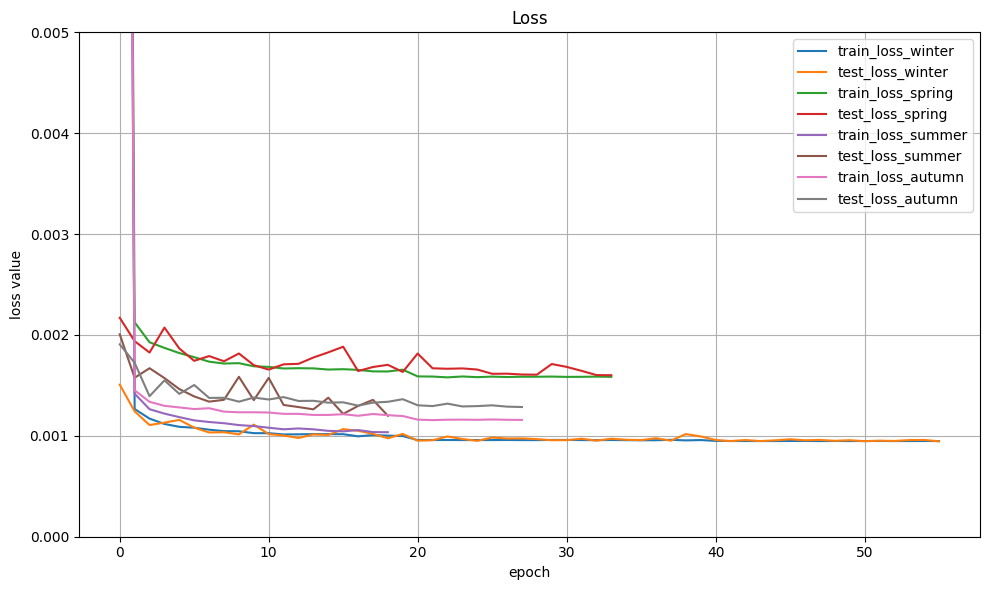

In [16]:
def display_fit():
    plt.figure(figsize=(10, 6))  # Optionnel, pour une meilleure taille de figure

    for season in seasons:
        train_loss = globals()[f"train_loss_per_epoch_{season}"]
        test_loss = globals()[f"test_loss_per_epoch_{season}"]

        sns.lineplot(x=train_loss.index, y=train_loss.iloc[:, 0], label=f"train_loss_{season}")
        sns.lineplot(x=test_loss.index, y=test_loss.iloc[:, 0], label=f"test_loss_{season}")

    plt.title("Loss")
    plt.xlabel('epoch')
    plt.ylabel('loss value')
    plt.ylim(0, 0.005)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

display_fit()

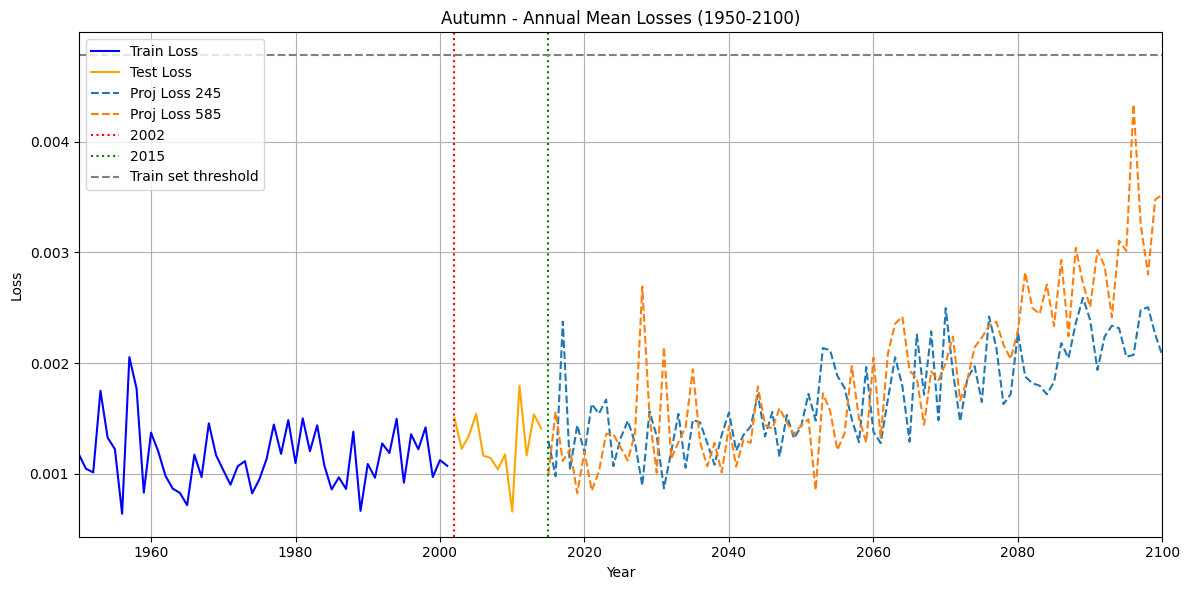

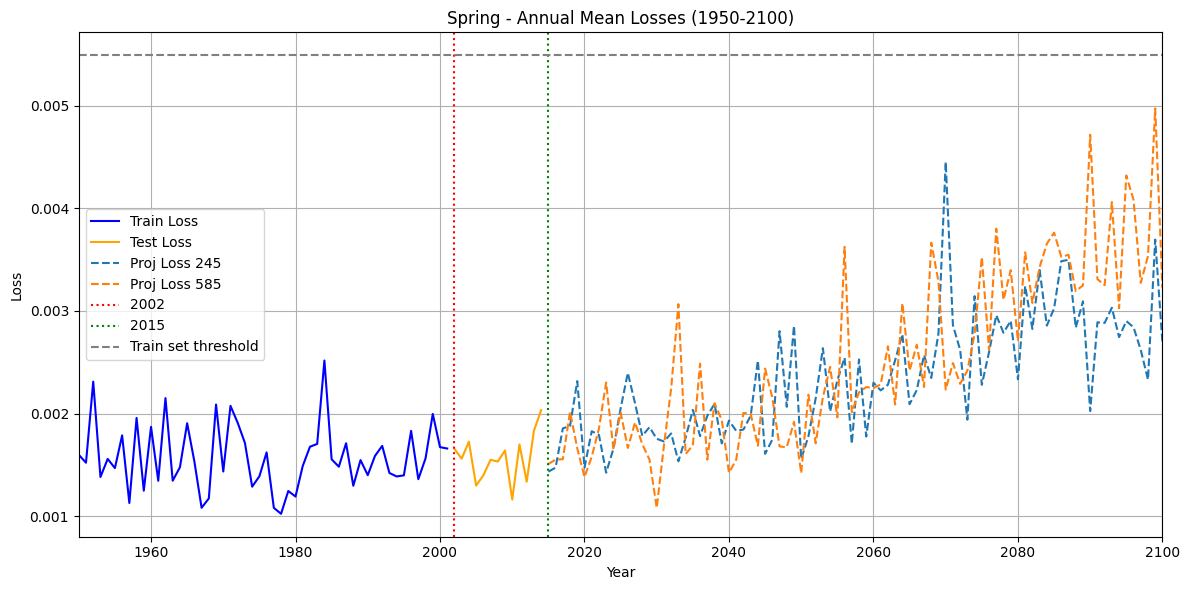

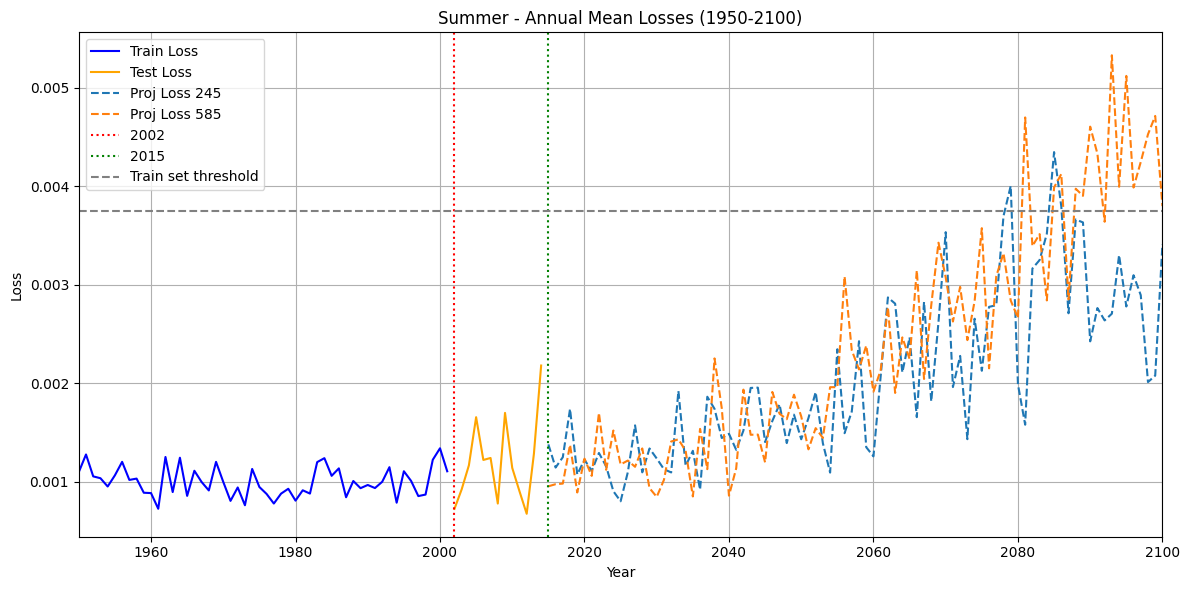

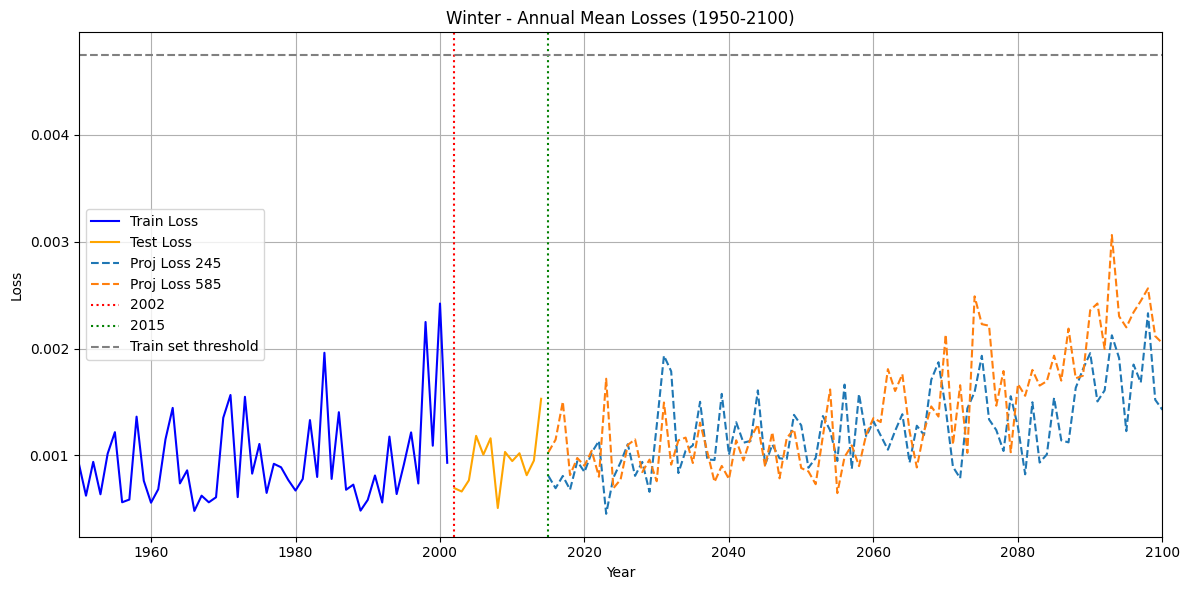

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os


def plot_losses(season: str, average: str = 'year', percentile: int = 99):
    """
    Trace train, test, and projection losses for a given season on a single plot,
    with vertical lines at 2002 and 2014.

    Parameters:
    - season: 'winter', 'spring', 'summer', or 'autumn'.
    - average: 'year' or 'season', to plot yearly or seasonal means.
    """
    # Load data dynamically from CSV files
    base_path = './inputs'
    train_time = pd.read_csv(f"./inputs/dates_train_{season}_data_1memb.csv")
    train_loss = pd.read_csv(f"./outputs/train_loss_indiv_{season}_1d_1memb.csv")
    test_time = pd.read_csv(f"./inputs/dates_test_{season}_data_1memb.csv")
    test_loss = pd.read_csv(f"./outputs/test_loss_indiv_{season}_1d_1memb.csv")
    proj_time = pd.read_csv(f"./inputs/dates_proj_{season}_data_1memb.csv")
    proj_losses = {
        '245': pd.read_csv(f"./outputs/proj245_loss_indiv_{season}_1d_1memb.csv"),
        '585': pd.read_csv(f"./outputs/proj585_loss_indiv_{season}_1d_1memb.csv")
    }
    
    threshold = train_loss['0'].quantile(percentile / 100)

    # Helper: build a series
    def make_series(time_df, loss_df):
        ts = pd.to_datetime(time_df.iloc[:, 1])
        ls = loss_df.iloc[:, 1].astype(float)
        return pd.Series(data=ls.values, index=ts, name='loss')

    s_train = make_series(train_time, train_loss)
    s_test = make_series(test_time, test_loss)
    s_proj = {label: make_series(proj_time, df) for label, df in proj_losses.items()}

    # Optionally group
    def group_series(s: pd.Series):
        if average == 'year':
            return s.resample('YE').mean().rename(s.name)
        elif average == 'season':
            # Define meteorological seasons
            seasons = ((s.index.month % 12 + 3) // 3)
            df = pd.DataFrame({'loss': s.values, 'year': s.index.year, 'season': seasons})
            df.loc[(df['season'] == 1) & (s.index.month == 12), 'year'] += 1
            grouped = df.groupby(['year', 'season'])['loss'].mean()
            season_month_day = {1: '-02-15', 2: '-05-15', 3: '-08-15', 4: '-11-15'}
            season_month_day = {1: '-01-01', 2: '-04-01', 3: '-07-01', 4: '-10-01'}
            dates = grouped.index.to_frame()
            dates['date'] = pd.to_datetime(dates['year'].astype(str) + dates['season'].map(season_month_day))
            grouped.index = dates['date']
            return grouped.rename(s.name)
        else:
            raise ValueError("average must be 'year' or 'season'")

    # Group if needed
    if average in ['year', 'season']:
        s_train_g = group_series(s_train)
        s_test_g = group_series(s_test)
        s_proj_g = {label: group_series(s) for label, s in s_proj.items()}
    else:
        s_train_g, s_test_g, s_proj_g = s_train, s_test, s_proj

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(s_train_g.index.year if average == 'year' else s_train_g.index,
             s_train_g.values, label='Train Loss', color='blue')
    plt.plot(s_test_g.index.year if average == 'year' else s_test_g.index,
             s_test_g.values, label='Test Loss', color='orange')
    for label, series in s_proj_g.items():
        plt.plot(series.index.year if average == 'year' else series.index,
                 series.values, label=f'Proj Loss {label}', linestyle='--')

    plt.axvline(x=2002, color='red', linestyle=':', label='2002')
    plt.axvline(x=2015, color='green', linestyle=':', label='2015')
    plt.axhline(y=threshold, color='grey', linestyle='--', label='Train set threshold')
    plt.xlim(1950, 2100)
    plt.xlabel('Year')
    plt.ylabel('Loss')
    plt.title(f'{season.capitalize()} - {"Annual" if average=="year" else "Seasonal"} Mean Losses (1950-2100)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Exemple d'appel :
plot_losses('autumn', average='year')
plot_losses('spring', average='year')
plot_losses('summer', average='year')
plot_losses('winter', average='year')

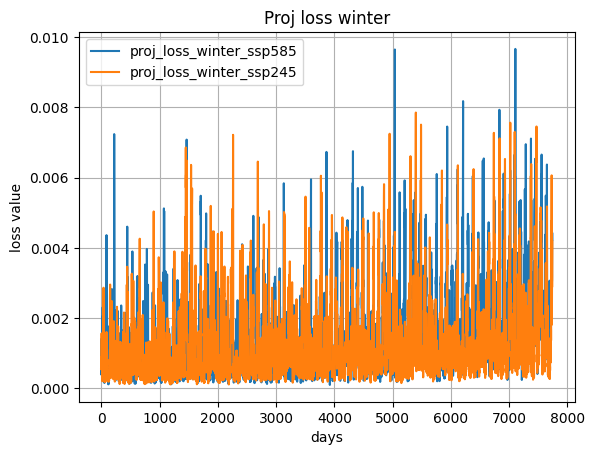

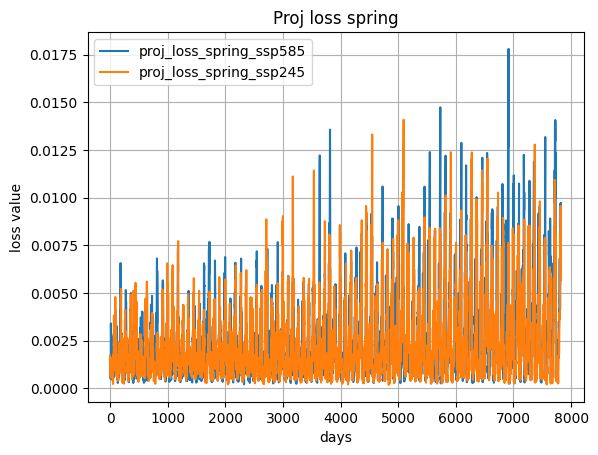

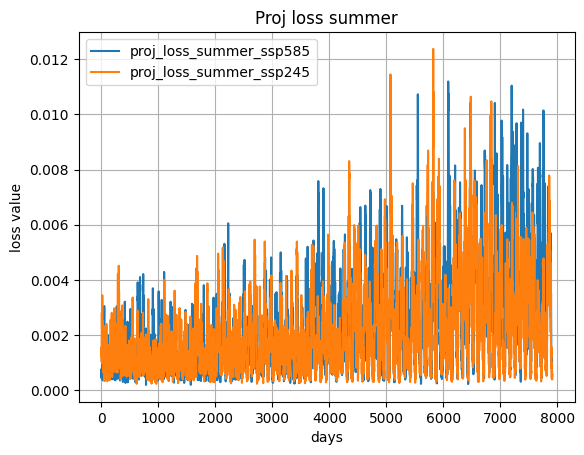

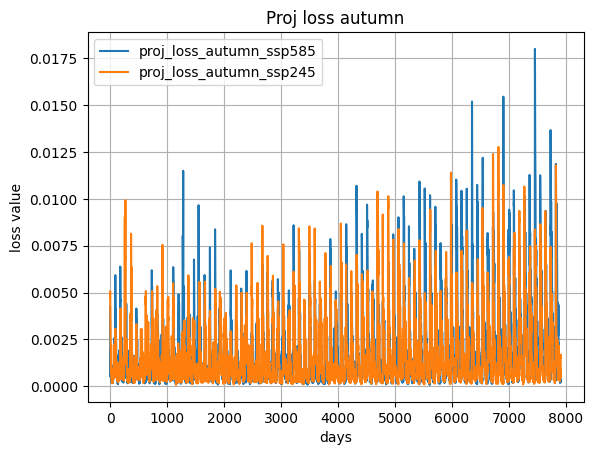

In [7]:
def display_proj_loss():
    for season in seasons:
        for scenario in scenarios:
            proj_loss = globals()[f"proj_loss_{season}_{scenario}"]
            if "Unnamed: 0" in proj_loss.columns:
                proj_loss = proj_loss.drop(columns=["Unnamed: 0"])
            plt.plot(proj_loss, label=f"proj_loss_{season}_ssp{scenario}")
        plt.title(f"Proj loss {season}")
        plt.legend()
        plt.xlabel('days')
        plt.ylabel('loss value')
        plt.grid(True)
        plt.show()

display_proj_loss()

In [10]:
def display_loss(scenario, day_range=None, year_range=None, aggregation="none"):
    proj_loss_combined = []
    num_blocks = len(globals()[f"proj_loss_winter_{scenario}"])
    num_years = num_blocks // season_sizes['winter']  # Nombre d'années simulées

    for year_idx in range(num_years):
        for season in seasons:
            loss_df = globals()[f"proj_loss_{season}_{scenario}"]
            season_len = season_sizes[season]
            start = year_idx * season_len
            end = start + season_len
            season_chunk = loss_df.iloc[start:end, 1].values  # Colonne des valeurs de loss
            proj_loss_combined.extend(season_chunk)

    loss_series = pd.Series(proj_loss_combined)

    if day_range is not None:
        start, end = day_range
        loss_series = loss_series.iloc[start:end]
        title = f"ssp{scenario} - jours {start} à {end}"
    elif year_range is not None:
        start_year_idx, end_year_idx = year_range
        start_day = start_year_idx * total_days_per_year
        end_day = end_year_idx * total_days_per_year
        loss_series = loss_series.iloc[start_day:end_day]
        title = f"ssp{scenario} - années {start_year_idx} à {end_year_idx}"
    else:
        title = f"ssp{scenario}"

    if aggregation == "month":
        grouped = loss_series.groupby(loss_series.index // 30).mean()
    elif aggregation == "season":
        grouped = []
        idx = 0
        while idx < len(loss_series):
            for season in seasons:
                season_len = season_sizes[season]
                chunk = loss_series.iloc[idx:idx + season_len]
                if len(chunk) < season_len:
                    break
                grouped.append(chunk.mean())
                idx += season_len
        grouped = pd.Series(grouped)
    elif aggregation == "year":
        grouped = loss_series.groupby(loss_series.index // total_days_per_year).mean()
    else:
        grouped = loss_series

    start_year = 2015
    if aggregation == "day":
        unit_per_year = total_days_per_year
    elif aggregation == "month":
        unit_per_year = 12  # mois par année
    elif aggregation == "season":
        unit_per_year = len(seasons)  # saisons par année
    elif aggregation == "year":
        unit_per_year = 1  # agrégé par année
    else:
        raise ValueError(f"Aggregation inconnue: {aggregation}")

    tick_interval = unit_per_year * 5  # tous les 5 ans
    total_points = len(grouped)
    xticks_pos = list(range(0, total_points, tick_interval))
    xticks_labels = [f"Year {start_year + i*5}" for i in range(len(xticks_pos))]

    plt.plot(grouped.reset_index(drop=True))
    plt.xticks(xticks_pos, xticks_labels, rotation=45)
    plt.title(f"Projection loss - {title} (per {aggregation})")
    plt.ylabel("Loss value")
    plt.grid(True)
    plt.tight_layout()
    return grouped.reset_index(drop=True)

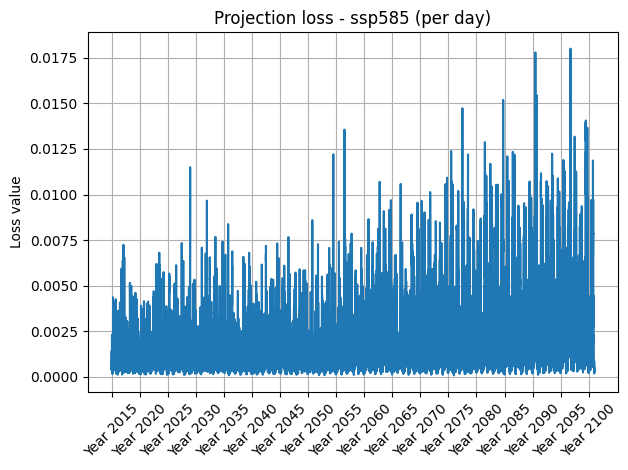

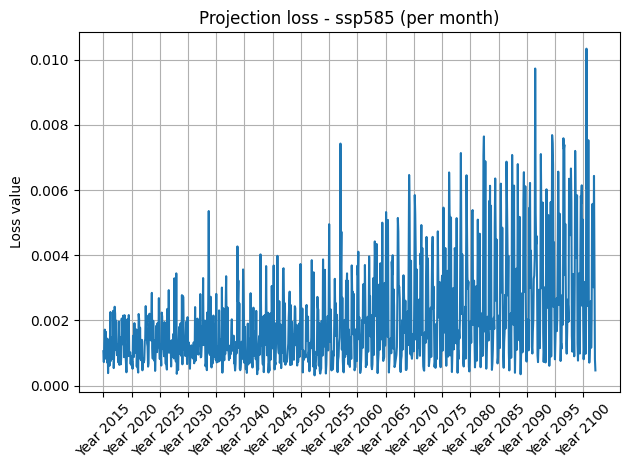

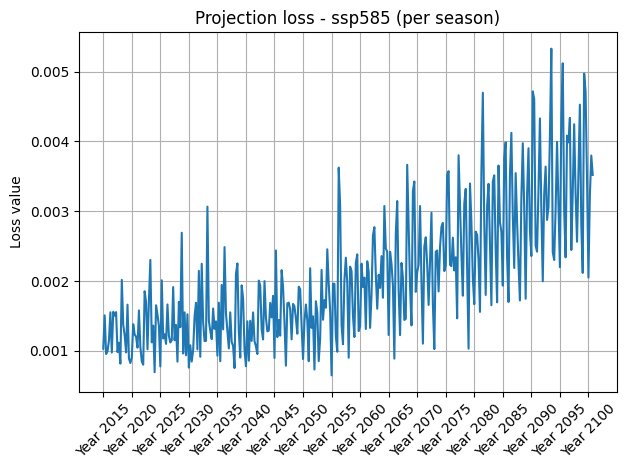

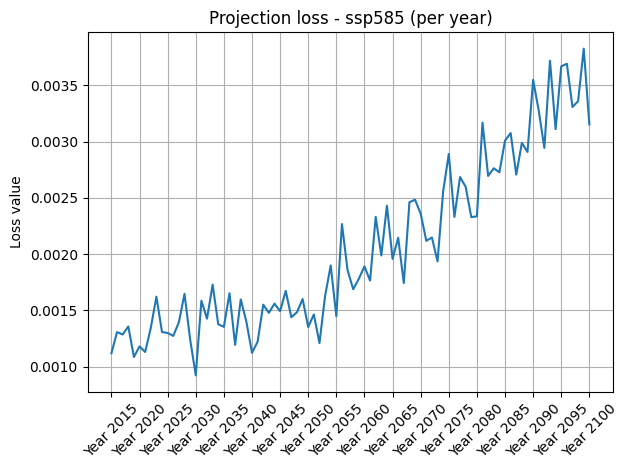

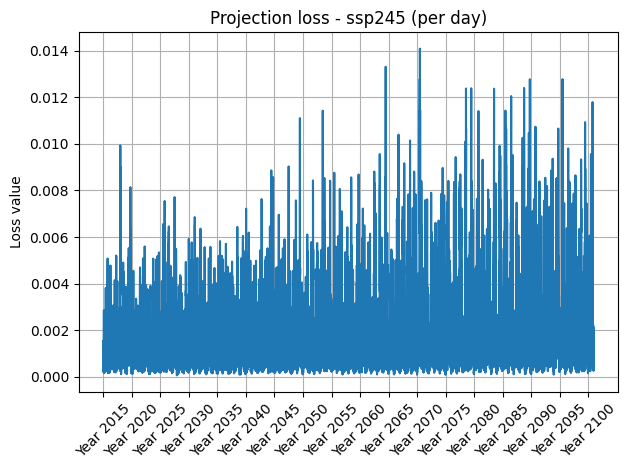

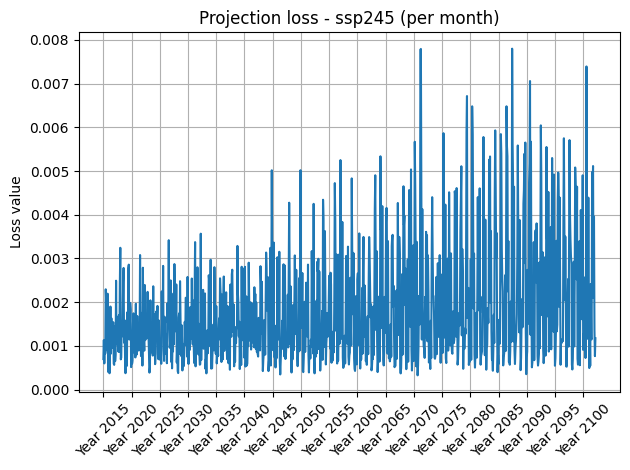

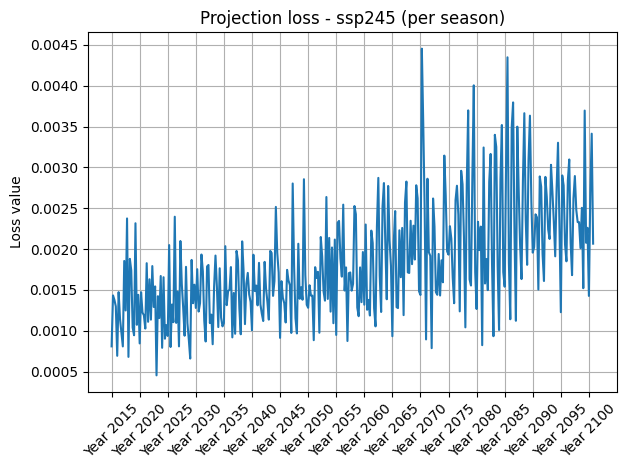

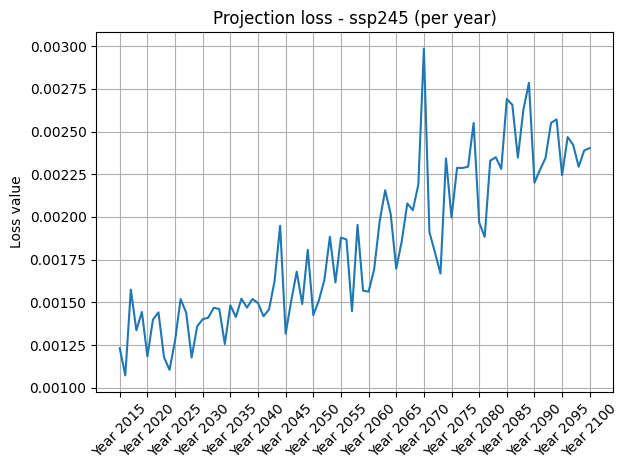

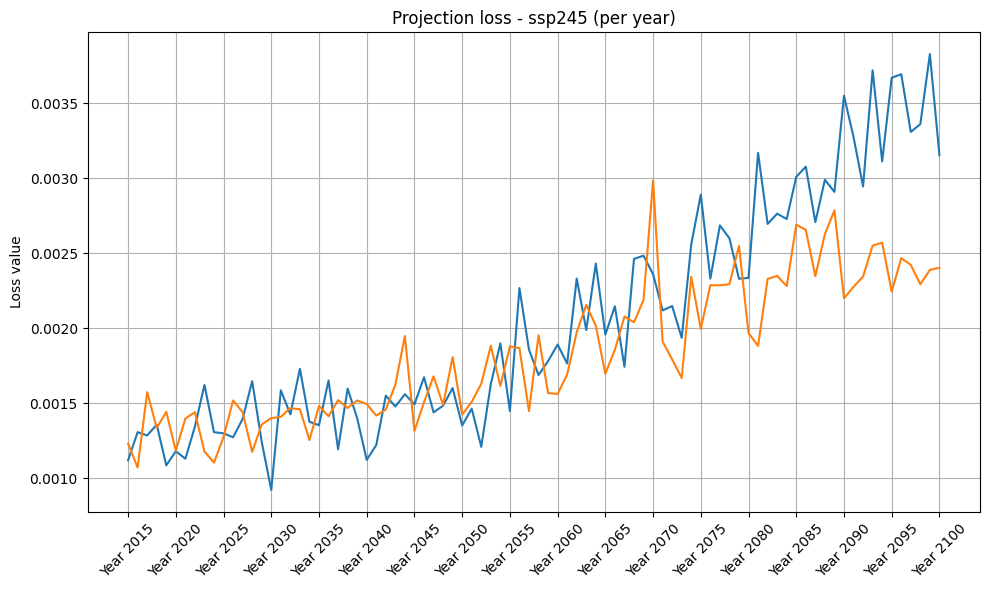

In [11]:
globals()[f"loss_per_day"] = []
globals()[f"loss_per_month"] = []
globals()[f"loss_per_season"] = []
globals()[f"loss_per_year"] = []

for scenario in scenarios:
    globals()[f"loss_{scenario}_day"] = display_loss(scenario, aggregation="day")
    plt.show()
    globals()[f"loss_{scenario}_month"] = display_loss(scenario, aggregation="month")
    plt.show()
    globals()[f"loss_{scenario}_season"] = display_loss(scenario, aggregation="season")
    plt.show()
    globals()[f"loss_{scenario}_year"] = display_loss(scenario, aggregation="year")
    plt.show()
    
    globals()[f"loss_per_day"].append(globals()[f"loss_{scenario}_day"])
    globals()[f"loss_per_month"].append(globals()[f"loss_{scenario}_month"])
    globals()[f"loss_per_season"].append(globals()[f"loss_{scenario}_season"])
    globals()[f"loss_per_year"].append(globals()[f"loss_{scenario}_year"])
    
plt.figure(figsize=(10, 6))
for scenario in scenarios:
    globals()[f"loss_{scenario}_year"] = display_loss(scenario, aggregation="year")
plt.show()

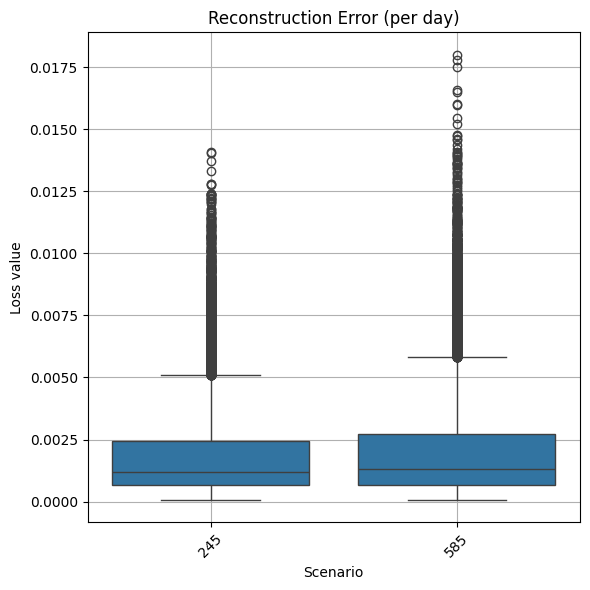

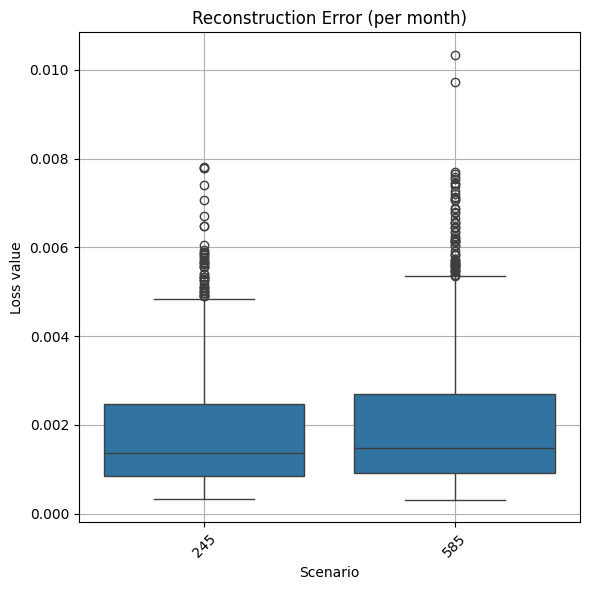

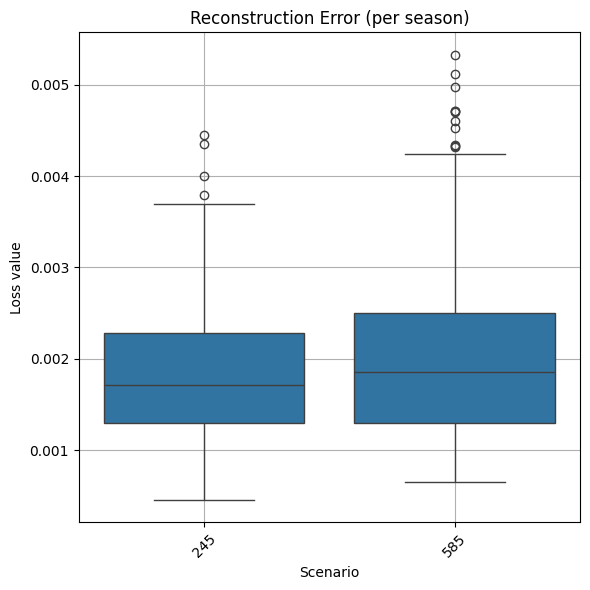

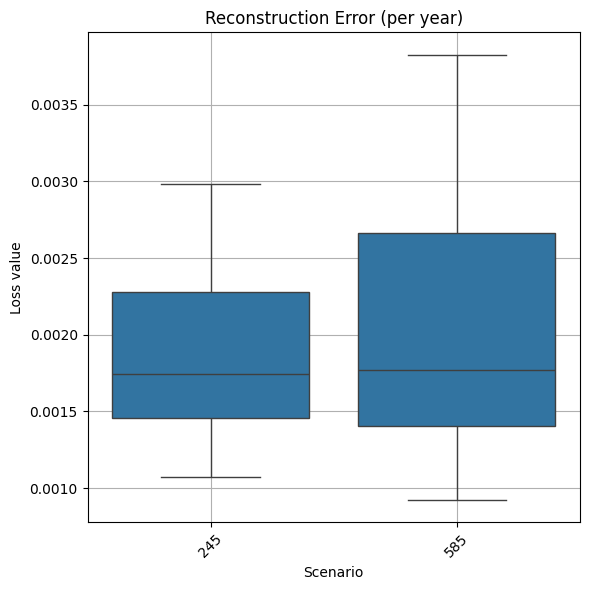

In [12]:
aggregation_type = ["day", "month", "season", "year"]

for agg in aggregation_type:
    data = globals()[f"loss_per_{agg}"]  # liste de listes
    data_long = []

    for i, scenario in enumerate(scenarios):
        scenario_losses = data[i]
        for value in scenario_losses:
            data_long.append({
                "Scenario": scenario,
                "Loss value": value
            })

    df_long = pd.DataFrame(data_long)

    plt.figure(figsize=(6, 6))
    sns.boxplot(x="Scenario", y="Loss value", data=df_long)
    plt.xticks(rotation=45)
    plt.title(f"Reconstruction Error (per {agg})")
    plt.xlabel("Scenario")
    plt.ylabel("Loss value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Mapping of month to meteorological season
SEASON_MAP = {
    12: 'winter', 1: 'winter', 2: 'winter',
    3: 'spring', 4: 'spring', 5: 'spring',
    6: 'summer', 7: 'summer', 8: 'summer',
    9: 'autumn', 10: 'autumn', 11: 'autumn'
}


def load_and_index_loss(data_type, seasons, scenarios=None):
    """
    Charge et concatène les séries journalières de loss pour un type donné.
    data_type: 'train', 'test', ou 'proj'
    seasons: liste des saisons ['winter', 'spring', 'summer', 'autumn']
    scenarios: liste des scénarios pour 'proj' (e.g. ['585', '245']), None sinon
    Retour:
      - si data_type!='proj': pd.Series indexée par datetime
      - si 'proj': dict de pd.Series par scénario
    """
    if data_type in ['train', 'test']:
        series_list = []
        for season in seasons:
            df = pd.read_csv(f"./outputs/{data_type}_loss_indiv_{season}_1d_1memb.csv", header=None, names=['loss'])
            series_list.append(df['loss'])
        all_vals = pd.concat(series_list, ignore_index=True)
        # Date ranges selon le type
        if data_type == 'train':
            start = '1950-01-01'
            end = None  # déterminé par longueur
        else:
            start = '2002-01-01'
        dates = pd.date_range(start=start, periods=len(all_vals), freq='D')
        return pd.Series(all_vals.values, index=dates, name=f"{data_type}_loss")
    elif data_type == 'proj':
        proj_series = {}
        for scenario in scenarios:
            series_list = []
            for season in seasons:
                df = pd.read_csv(f"./outputs/proj{scenario}_loss_indiv_{season}_1d_1memb.csv", header=None, names=['loss'])
                series_list.append(df['loss'])
            all_vals = pd.concat(series_list, ignore_index=True)
            dates = pd.date_range(start='2015-01-01', periods=len(all_vals), freq='D')
            proj_series[scenario] = pd.Series(all_vals.values, index=dates, name=f"proj_loss_{scenario}")
        return proj_series


def aggregate_series(series, mode='season'):
    """
    Agrège la série selon le mode choisi: 'season' ou 'year'.
    Retourne une pd.Series indexée par le début de la période.
    """
    if mode == 'year':
        # Moyenne annuelle
        return series.resample('YE').mean()
    elif mode == 'season':
        # Ajoute colonnes year et season
        df = series.to_frame('loss')
        df['month'] = df.index.month
        df['year'] = df.index.year
        df['season'] = df['month'].map(SEASON_MAP)
        # Ajustement pour l'hiver: les mois Décembre affectés à l'année suivante
        winter = (df['season'] == 'winter') & (df['month'] == 12)
        df.loc[winter, 'year'] += 1
        # Moyenne par (year, season)
        grp = df.groupby(['year', 'season'])['loss'].mean()
        # Création d'un index temporel pour le rendu graphique (le premier jour de la saison)
        idx = []
        for (yr, seas) in grp.index:
            if seas == 'winter':
                idx.append(pd.Timestamp(f"{yr}-01-01"))
            elif seas == 'spring':
                idx.append(pd.Timestamp(f"{yr}-03-01"))
            elif seas == 'summer':
                idx.append(pd.Timestamp(f"{yr}-06-01"))
            elif seas == 'autumn':
                idx.append(pd.Timestamp(f"{yr}-09-01"))
        seasonal = pd.Series(grp.values, index=idx)
        seasonal.index.name = 'date'
        seasonal.name = series.name
        return seasonal
    else:
        raise ValueError("Mode d'agrégation invalide: choisissez 'season' ou 'year'.")


def plot_losses(seasons, scenarios, agg_mode='season'):
    """
    Charge les losses, agrège selon agg_mode ('season' ou 'year') et trace le graphique.
    Affiche train_loss (1950-2001), test_loss (2002-2014), et proj_loss pour chaque scenario (2015-2100).
    Crée deux asymptotes verticales à 2002 et 2014.
    """
    # Charger les séries
    train = load_and_index_loss('train', seasons)
    test = load_and_index_loss('test', seasons)
    proj = load_and_index_loss('proj', seasons, scenarios)

    # Agréger
    train_agg = aggregate_series(train, mode=agg_mode)
    test_agg = aggregate_series(test, mode=agg_mode)
    proj_agg = {sc: aggregate_series(srs, mode=agg_mode) for sc, srs in proj.items()}

    # Plot
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(train_agg.index, train_agg.values, label='Train Loss (1950-2001)')
    ax.plot(test_agg.index, test_agg.values, label='Test Loss (2002-2014)')
    for sc, ser in proj_agg.items():
        ax.plot(ser.index, ser.values, label=f'Proj Loss {sc} (2015-2100)')

    # Asymptotes
    ax.axvline(pd.Timestamp('2002-01-01'), linestyle='--', color='grey')
    ax.axvline(pd.Timestamp('2015-01-01'), linestyle='--', color='grey')

    # Format x-axis
    ax.set_xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2100-12-31'))
    ax.xaxis.set_major_locator(mdates.YearLocator(base=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.set_xlabel('Année')
    ax.set_ylabel('Loss moyenne par ' + ('saison' if agg_mode=='season' else 'année'))
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

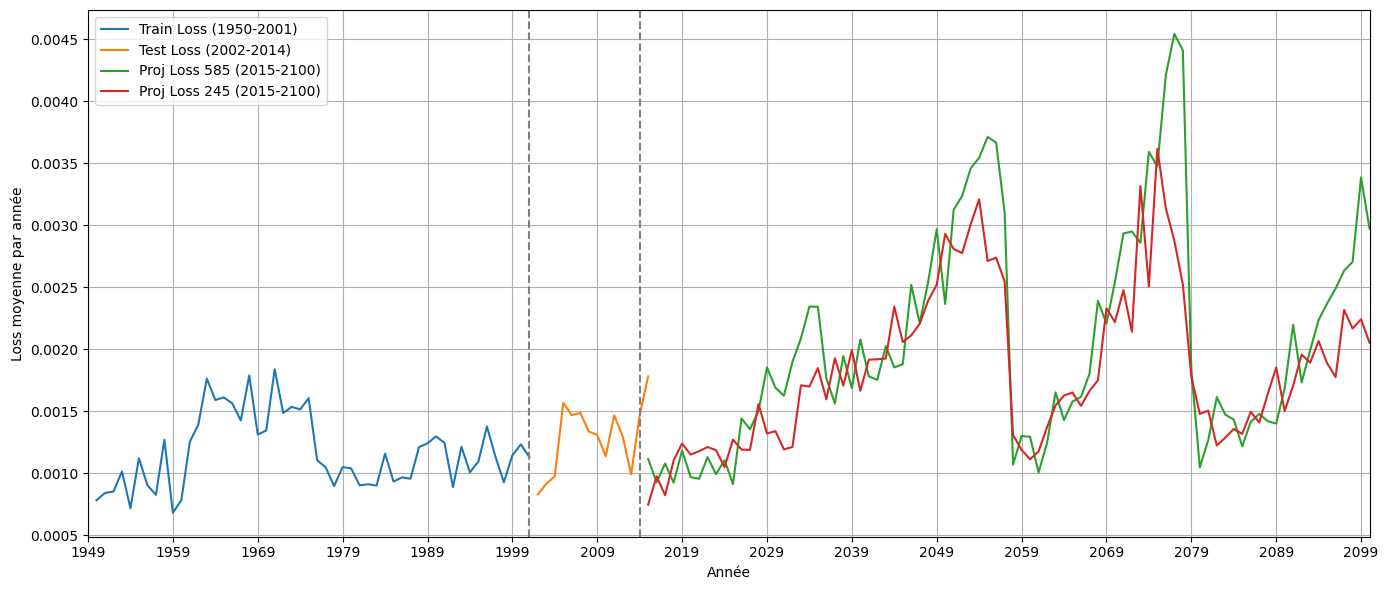

In [18]:
plot_losses(seasons, scenarios, agg_mode='year')  # ou agg_mode='year'